## AutoEncoder-Pytorch-example

In [1]:
%load_ext lab_black

In [2]:
import os
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import LambdaLR
from torchvision.datasets import MNIST
import pylab
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
class Mnisttox(Dataset):
    def __init__(self, datasets, labels: list):
        self.dataset = [
            datasets[i][0] for i in range(len(datasets)) if datasets[i][1] in labels
        ]
        self.labels = labels
        self.len_oneclass = int(len(self.dataset) / 10)

    def __len__(self):
        return int(len(self.dataset))

    def __getitem__(self, index):
        img = self.dataset[index]
        return img, []


class Autoencoder(nn.Module):
    def __init__(self, input_size, z_dim):
        super(Autoencoder, self).__init__()

        # define the network
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, z_dim)
        self.layer4 = nn.Linear(z_dim, 128)
        self.layer5 = nn.Linear(128, 256)
        self.layer6 = nn.Linear(256, input_size)

        self.encoder = nn.Sequential(
            self.layer1, nn.ReLU(True), self.layer2, nn.ReLU(True), self.layer3
        )
        self.decoder = nn.Sequential(
            self.layer4, nn.ReLU(True), self.layer5, nn.ReLU(True), self.layer6
        )

    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat

### deviceの定義

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### データセットのインスタンス化

In [5]:
img_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]  # [0,1] => [-1,1]
)
train_dataset = MNIST("./data", download=True, train=True, transform=img_transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



102.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



112.7%


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/tmp/Python/python-3.9.6/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### データセットをデータローダに変換

In [6]:
batch_size = 100
train_1 = Mnisttox(train_dataset, [1])
train_loader = DataLoader(train_1, batch_size=batch_size, shuffle=True)

### モデルのインスタンス化

In [7]:
input_size = 28 * 28
z_dim = 64

num_epochs = 200
learning_rate = 1e-4
n = 6  # number of test sample

model = Autoencoder(input_size, z_dim).to(device)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

### 学習率の変化を設定

In [8]:
def func_100(epoch):
    if epoch <= 100:
        return 1
    elif 100 < epoch:
        return -0.99 * (1e-2) * (epoch) + 1.99

In [9]:
scheduler = LambdaLR(optimizer, lr_lambda=func_100)

### モデルの学習

In [10]:
model.train()
losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    i = 0
    for img, _ in train_loader:

        x = img.view(img.size(0), -1)
        x = Variable(x).to(device)
        xhat = model(x)

        # 出力画像（再構成画像）と入力画像の間でlossを計算
        loss = mse_loss(xhat, x)
        losses[epoch] = losses[epoch] * (i / (i + 1.0)) + loss * (1.0 / (i + 1.0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
    print("epoch [{}/{}], loss: {:.4f}".format(epoch + 1, num_epochs, loss))
    scheduler.step()

epoch [1/200], loss: 0.1573
epoch [2/200], loss: 0.1155
epoch [3/200], loss: 0.1121
epoch [4/200], loss: 0.0803
epoch [5/200], loss: 0.0756
epoch [6/200], loss: 0.0608
epoch [7/200], loss: 0.0557
epoch [8/200], loss: 0.0508
epoch [9/200], loss: 0.0382
epoch [10/200], loss: 0.0376
epoch [11/200], loss: 0.0414
epoch [12/200], loss: 0.0399
epoch [13/200], loss: 0.0334
epoch [14/200], loss: 0.0361
epoch [15/200], loss: 0.0426
epoch [16/200], loss: 0.0355
epoch [17/200], loss: 0.0363
epoch [18/200], loss: 0.0377
epoch [19/200], loss: 0.0329
epoch [20/200], loss: 0.0238
epoch [21/200], loss: 0.0342
epoch [22/200], loss: 0.0269
epoch [23/200], loss: 0.0248
epoch [24/200], loss: 0.0324
epoch [25/200], loss: 0.0260
epoch [26/200], loss: 0.0257
epoch [27/200], loss: 0.0232
epoch [28/200], loss: 0.0348
epoch [29/200], loss: 0.0277
epoch [30/200], loss: 0.0259
epoch [31/200], loss: 0.0210
epoch [32/200], loss: 0.0234
epoch [33/200], loss: 0.0239
epoch [34/200], loss: 0.0207
epoch [35/200], loss: 0

### グラフの描画

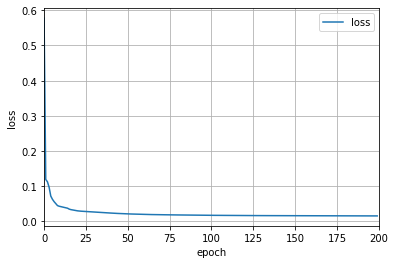

In [11]:
plt.figure()
pylab.xlim(0, num_epochs)
plt.plot(range(0, num_epochs), losses, label="loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()

### 評価

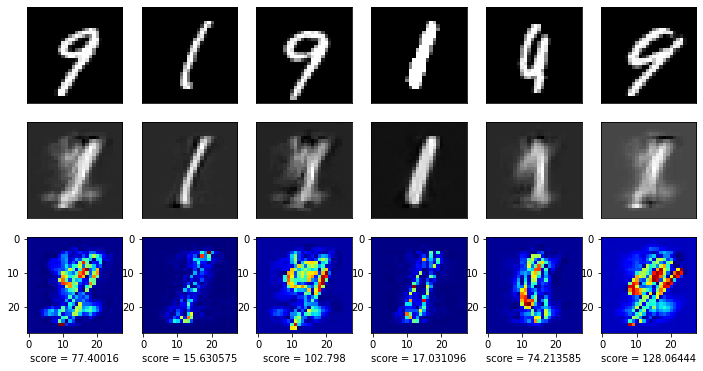

In [12]:
test_dataset = MNIST("./data", train=False, download=True, transform=img_transform)
test_1_9 = Mnisttox(test_dataset, [1, 9])
test_loader = DataLoader(test_1_9, batch_size=len(test_dataset), shuffle=True)

for img, _ in test_loader:
    x = img.view(img.size(0), -1)
    x = Variable(x).to(device)

    xhat = model(x)
    x = x.cpu().detach().numpy()
    xhat = xhat.cpu().detach().numpy()
    x = x / 2 + 0.5
    xhat = xhat / 2 + 0.5

# サンプル画像表示
plt.figure(figsize=(12, 6))
for i in range(n):
    # テスト画像を表示
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 出力画像を表示
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(xhat[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 入出力の差分画像を計算
    diff_img = np.abs(x[i] - xhat[i])

    # 入出力の差分数値を計算
    diff = np.sum(diff_img)

    # 差分画像と差分数値の表示
    ax = plt.subplot(3, n, i + 1 + n * 2)
    plt.imshow(diff_img.reshape(28, 28), cmap="jet")
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    ax.set_xlabel("score = " + str(diff))

plt.show()
plt.close()